In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from hparams import hparams
print(hparams)

{'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 80.0, 'mel_fmax': 7600.0, 'n_symbols': 256, 'symbols_embedding_dim': 512, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'n_frames_per_step': 1, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'max_decoder_steps': 1000, 'gate_threshold': 0.5, 'p_attention_dropout': 0.1, 'p_decoder_dropout': 0.1, 'attention_rnn_dim': 1024, 'attention_dim': 128, 'attention_location_n_filters': 32, 'attention_location_kernel_size': 31, 'postnet_embedding_dim': 512, 'postnet_kernel_size': 5, 'postnet_n_convolutions': 5, 'mask_padding': True}


### Model Init

In [3]:
from model import Tacotron2, Tacotron2Loss
from utils import sizeof_fmt

model = Tacotron2(hparams)
model = model.cuda()
step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = Tacotron2Loss()

print('done')

Model size 107.8MiB
done


### Create save directory

In [14]:
save_dir = 'save/'
!mkdir $save_dir

### Download checkpoint (optional)

In [15]:
!gdown https://drive.google.com/uc?id=1oLh0_BRgYTtcj6S60dfcFG-9Dkbfw0Dc
!mv save_130000 $save_dir

Downloading...
From: https://drive.google.com/uc?id=1oLh0_BRgYTtcj6S60dfcFG-9Dkbfw0Dc
To: /aiffel/aiffel/tacotron2/save_130000
100%|████████████████████████████████████████| 339M/339M [00:03<00:00, 85.6MB/s]


### Load checkpoint (optional)

In [16]:
load_path = 'save/save_130000'
checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
step = checkpoint['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('done')

done


### DataLoader Init

In [5]:
from torch.utils.data import DataLoader
from dataset import KSSDataset, TextMelCollate

dataset = KSSDataset(hparams, root_dir='kss_dataset/', meta_file='transcript.v.1.4.txt', max_length=1024)
train_loader = DataLoader(dataset, num_workers=1, shuffle=False, batch_size=16, collate_fn=TextMelCollate(n_frames_per_step=1))
print(train_loader)

### Train Step

In [6]:
def train_step(model, optimizer, batch):
    # Set model train mode
    model.train()
    # Set all gradients of weights to zero
    model.zero_grad()
    # x : (text_padded, input_lengths, mel_padded, max_len, output_lengths)
    # y : (mel_padded, gate_padded)
    x, y = model.parse_batch(batch)
    # y_pred : (mel_outputs, mel_outputs_postnet, gate_outputs, alignments)
    y_pred = model(x)
    # Get Loss
    loss = criterion(y_pred, y)
    # Get all gradients of weights
    loss.backward()
    # Gradient clipping for stable training
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
    # Apply gradients to weights
    optimizer.step()
    
    return x, y, y_pred, loss

### Plot

In [7]:
import librosa.display
from IPython import display
import matplotlib.pyplot as plt

def plot(x, y, y_pred):
    # x : (text_padded, input_lengths, mel_padded, max_len, output_lengths)
    # y : (mel_padded, gate_padded)
    # y_pred : (mel_outputs, mel_outputs_postnet, gate_outputs, alignments)
    display.clear_output()
            
    _alignment = y_pred[3].data.cpu().numpy()
    plt.figure(figsize=[18, 3])
    plt.suptitle('Attention Alignments')
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(_alignment[i].T, aspect='auto', origin='lower', interpolation='none')
    plt.show()

    _mel_gt = x[2].data.cpu().numpy()
    _mel_pred = y_pred[1].data.cpu().numpy()

    plt.figure(figsize=[18, 3])
    plt.title('Ground Truth')
    librosa.display.specshow(_mel_gt[2])
    plt.colorbar()
    plt.show()

    plt.figure(figsize=[18, 3])
    plt.title('Prediction')
    librosa.display.specshow(_mel_pred[2])
    plt.colorbar()
    plt.show()

### Train Loop

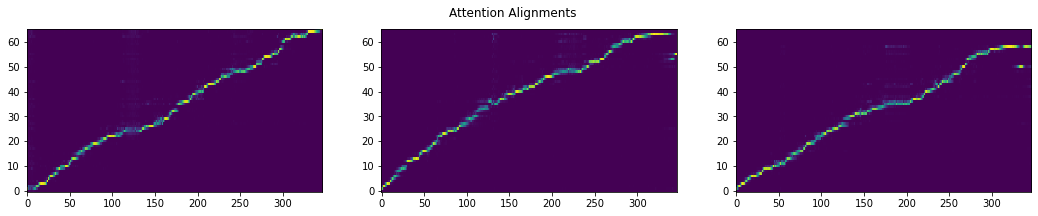

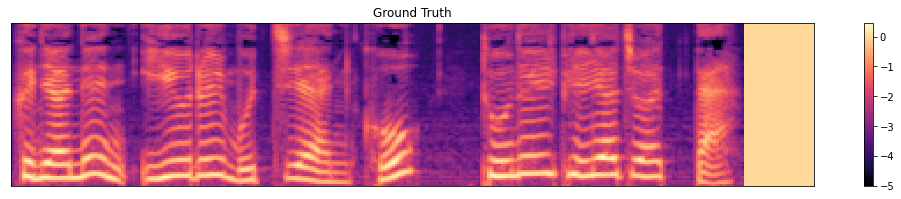

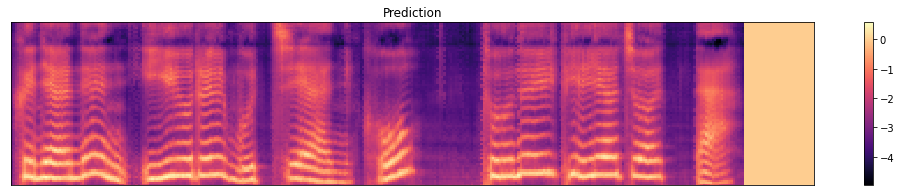

step : 130001 loss : 0.0928
step : 130002 loss : 0.0933
step : 130003 loss : 0.0792


KeyboardInterrupt: 

In [9]:
while(True):
    for batch in train_loader:
        x, y, y_pred, loss = train_step(model, optimizer, batch)
        print('step :', step, 'loss :', '%0.4f' % loss.item())
        
        if step % 1000 == 0: # Save checkpoint
            save_path = save_dir + 'save_' + str(step) 
            torch.save({'step': step,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()}, save_path)
        
        if step % 100 == 0:
            plot(x, y, y_pred)
            
        step += 1